In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gan3d

# using the code from the paper

In [3]:
import sys
import os

import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk

from mpl_toolkits import mplot3d

In [13]:
x = getVoxelFromMat("data/3DShapeNets/volumetric_data/chair/30/train/chair_000000814_8.mat")

(32, 32, 32)


In [ ]:
X = getAll("chair")
X = np.expand_dims(X, 4)

In [ ]:
train_bf = BatchFeeder(X, batch_size=32)

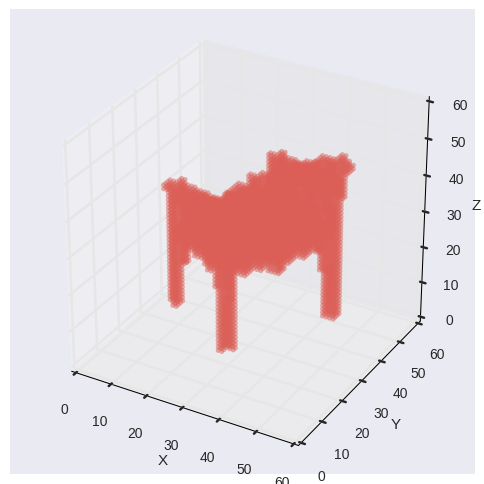

In [9]:
plotVoxel(train_bf.next()[0,:,:,:,0])

# 3DGAN 

In [6]:
class GAN3D:
    def __init__(self):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Define parameters of the encoder
        self.input_dim = (64,64,64,1)
        
        # Dimension of the sub-netowrks.
        self.encoder_dim = [512, 256, 128, 64, 1] # do we really need to go down to 1?
        self.generator_dim = [512, 256, 128, 64, 1]
        self.discriminator_dim = [64, 128, 256, 512, 1]
        self.latent_dim = 64
        self.batchsize = 32
        
        # Activation function is tf.nn.elu
        self.gen_fn = tf.nn.relu
        self.dis_fn = tf.nn.elu
        
        # Other parameters
        self._lambda = 0.0
        self.learning_rate = 0.001
        self._dropout = 1.0
        self.training = True
        
        # Build netowrk
        self.built = False
        self.sesh = tf.Session()
        self.e = 0
        
        # Tracking data
        self.learning_curve = []
        self.record = {"generated":[]}
        
        # Building the graph
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
    
    def build(self):
        # Placeholders for input and dropout probs.
        if self.built:
            return -1
        else:
            self.built = True
        
        x = tf.placeholder(tf.float32, shape=[self.batchsize]+list(self.input_dim), name="x")
        #dropout = tf.placeholder(tf.float32, shape=[], name="dropout_keepprob") no dropout for now.
        
        # Placeholder for latent z (sample from 0 mean 1 stddiv gaussian)
        #z = tf.placeholder(tf.float32, shape=[self.batchsize, 200])
        z = tf.random_normal(shape=[self.batchsize, 200])
        
        # defining G(z)
        generated = self.generator(z)
        
        # defining D(G(z)) and D(x)
        dgz, dgz_pre = self.discriminator(generated)
        dx, dx_pre = self.discriminator(x, reuse=True)
        
        # Compute losses
        d_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dx_pre, labels=tf.ones_like(dx))\
        + tf.nn.sigmoid_cross_entropy_with_logits(logits=dgz_pre, labels=tf.zeros_like(dgz))
        g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dgz_pre, labels=tf.ones_like(dgz))
        d_loss = tf.reduce_mean(d_loss)
        g_loss = tf.reduce_mean(g_loss)
        
        # Compute discriminator accuracy
        x_correct = tf.reduce_sum(tf.cast(dx > 0.5, tf.int32))
        z_correct = tf.reduce_sum(tf.cast(dgz < 0.5, tf.int32))
        acc = tf.divide(x_correct + z_correct, 2 * self.batchsize)
        
        # Get weights
        # PERHAPS DO GRADIENT CLIPPING?
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            g_vars = [v for v in tf.trainable_variables() if "generator" in v.name]
            d_vars = [v for v in tf.trainable_variables() if "discriminator" in v.name]
        
        # Update discriminator
        train_d = tf.train.AdamOptimizer(learning_rate=1e-5, beta1=0.5).minimize(d_loss,var_list=d_vars)
        # Update generator
        train_g = tf.train.AdamOptimizer(learning_rate=0.0025,beta1=0.5).minimize(g_loss,var_list=g_vars)
        
        # Exporting out the operaions as dictionary
        return dict(
            x = x,
            generated = generated,
            dx = dx,
            dgz = dgz,
            d_loss = d_loss,
            g_loss = g_loss,
            train_d = train_d,
            train_g = train_g,
            acc = acc
        )
    
    def discriminator(self, _input, reuse=None):
        with tf.variable_scope("discriminator", reuse=reuse):
            
            # layer 1
            n_filt = self.discriminator_dim[0]
            layer1 = tf.layers.conv3d(_input, n_filt, (4, 4, 4), strides=(2,2,2), padding="same", activation=None)
            layer1 = tf.contrib.layers.batch_norm(layer1, is_training=self.training)
            layer1 = self.dis_fn(layer1)
            
            # layer 2
            n_filt = self.discriminator_dim[1]
            layer2 = tf.layers.conv3d(layer1, n_filt, (4, 4, 4), strides=(2,2,2), padding="same", activation=None)
            layer2 = tf.contrib.layers.batch_norm(layer2, is_training=self.training)
            layer2 = self.dis_fn(layer2)
            
            # layer 3
            n_filt = self.discriminator_dim[2]
            layer3 = tf.layers.conv3d(layer2, n_filt, (4, 4, 4), strides=(2,2,2), padding="same", activation=None)
            layer3 = tf.contrib.layers.batch_norm(layer3, is_training=self.training)
            layer3 = self.dis_fn(layer3)
            
            # layer 4
            n_filt = self.discriminator_dim[3]
            layer4 = tf.layers.conv3d(layer3, n_filt, (4, 4, 4), strides=(2,2,2), padding="same", activation=None)
            layer4 = tf.contrib.layers.batch_norm(layer4, is_training=self.training)
            layer4 = self.dis_fn(layer4)
            
            # layer 5
            n_filt = self.discriminator_dim[4]
            layer5 = tf.layers.conv3d(layer4, n_filt, (4, 4, 4), strides=(1,1,1), padding="valid", activation=None)
            layer5 = tf.contrib.layers.batch_norm(layer5, is_training=self.training)
            output = tf.nn.sigmoid(layer5)
            
            return output, layer5
        
    
    def generator(self, _input, reuse=None):
        
        with tf.variable_scope("generator", reuse=reuse):
            _input = tf.reshape(_input, (self.batchsize, 1, 1, 1, 200))
            
            # layer 1 (outputs: 512x4x4x4)
            n_filt = self.generator_dim[0]
            layer1 = tf.layers.conv3d_transpose(_input, n_filt, (4, 4, 4), strides=(1,1,1), padding="valid", activation=None)
            layer1 = tf.contrib.layers.batch_norm(layer1, is_training=self.training)
            layer1 = self.gen_fn(layer1)
            
            # layer 2 (outputs: 256x8x8x8)
            n_filt = self.generator_dim[1]
            layer2 = tf.layers.conv3d_transpose(layer1, n_filt, (4, 4, 4), strides=(2,2,2), padding="same", activation=None)
            layer2 = tf.contrib.layers.batch_norm(layer2, is_training=self.training)
            layer2 = self.gen_fn(layer2)
            
            # layer 3 (outputs: 128x16x16x16)
            n_filt = self.generator_dim[2]
            layer3 = tf.layers.conv3d_transpose(layer2, n_filt, (4, 4, 4), strides=(2,2,2), padding="same", activation=None)
            layer3 = tf.contrib.layers.batch_norm(layer3, is_training=self.training)
            layer3 = self.gen_fn(layer3)
            
            # layer 4 (outputs: 64x32x32x32)
            n_filt = self.generator_dim[3]
            layer4 = tf.layers.conv3d_transpose(layer3, n_filt, (4, 4, 4), strides=(2,2,2), padding="same", activation=None)
            layer4 = tf.contrib.layers.batch_norm(layer4, is_training=self.training)
            layer4 = self.gen_fn(layer4)
            
            # layer 5 (outputs: 1x64x64x64)
            n_filt = self.generator_dim[4]
            layer5 = tf.layers.conv3d_transpose(layer4, n_filt, (4, 4, 4), strides=(2,2,2), padding="same", activation=None)
            layer5 = tf.contrib.layers.batch_norm(layer5, is_training=self.training)
            layer5 = tf.nn.sigmoid(layer5)
            
            return layer5
    
    # Closing session
    def close(self):
        self.sesh.close()
        
    def train(self, X, epochs):
        # Making the saver object.
        saver = tf.train.Saver()
        
        # Defining the number of batches per epoch
        batch_num = int(np.ceil(X.n*1.0/X.batch_size))
        
        e = 0
        while e < epochs:
            epoch_cost = {"dloss":[], "gloss":[]}
            
            if e == epochs-1: self.latent_record = {"generated":[]}
            
            for i in range(batch_num):
                if i%(batch_num/10)==0:
                    print i, batch_num
                #Training happens here.
                batch = X.next()
                feed_dict = {self.ops["x"]: batch}
                
                #Compute loss
                d_loss = self.sesh.run(self.ops["d_loss"], feed_dict)
                g_loss = self.sesh.run(self.ops["g_loss"], feed_dict)
                acc = self.sesh.run(self.ops["acc"], feed_dict)
                generated = self.sesh.run(self.ops["generated"], feed_dict)
                
                if acc < 0.8: # make it a parameter
                    self.sesh.run(self.ops["train_d"], feed_dict)
                self.sesh.run(self.ops["train_g"])
                
                #Record what you need
                if e == epochs-1: self.record["generated"] = self.record["generated"] + [_ for _ in generated]
                epoch_cost["dloss"].append(d_loss)
                epoch_cost["gloss"].append(g_loss)
            
            self.e+=1
            e+= 1
                
            print "Epoch:"+str(self.e), "Loss(D)", d_loss, "Loss(G)", g_loss
            self.learning_curve.append(epoch_cost)
            

In [7]:
model = GAN3D()

In [8]:
model.ops

{'acc': <tf.Tensor 'truediv:0' shape=() dtype=float64>,
 'd_loss': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
 'dgz': <tf.Tensor 'discriminator/Sigmoid:0' shape=(32, 1, 1, 1, 1) dtype=float32>,
 'dx': <tf.Tensor 'discriminator_1/Sigmoid:0' shape=(32, 1, 1, 1, 1) dtype=float32>,
 'g_loss': <tf.Tensor 'Mean_1:0' shape=() dtype=float32>,
 'generated': <tf.Tensor 'generator/Sigmoid:0' shape=(32, 64, 64, 64, 1) dtype=float32>,
 'train_d': <tf.Operation 'Adam' type=NoOp>,
 'train_g': <tf.Operation 'Adam_1' type=NoOp>,
 'x': <tf.Tensor 'x:0' shape=(32, 64, 64, 64, 1) dtype=float32>}

# Plot the generated figures.

In [30]:
d = model.latent_record["generated"][-1]

In [ ]:
plotVoxel(d, 0.5)